In [8]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta
import random
import sys
import subprocess
from collections import Counter

# --- ENSURE LIBRARIES ARE INSTALLED ---
try:
    print("Ensuring required libraries are installed...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pm4py", "matplotlib", "seaborn", "networkx", "-q"])
    import pm4py
    import matplotlib.pyplot as plt
    import seaborn as sns
    import networkx as nx
    from matplotlib.lines import Line2D # Import for custom legends
    print("✅ Libraries are ready.")
except Exception as e:
    print(f"An error occurred during library installation: {e}")
    sys.exit()

# Initialize Faker
fake = Faker()    

Ensuring required libraries are installed...
✅ Libraries are ready.


In [9]:
# --- 1. DATA SIMULATION (WITH KEY PERSON ROLES) ---
def simulate_event_log(num_cases=100):
    """
    Simulates an event log designed for organizational mining, including key person roles,
    different teams, and opportunities for context switching.
    """
    print("\nStep 1: Simulating event log for comprehensive organizational mining...")
    
    # Define roles and teams
    exploratory_team = [fake.name() for _ in range(5)]
    lead_scientist = fake.name() # Key Person 1
    exploitative_team = [fake.name() for _ in range(5)]
    senior_qa_manager = fake.name() # Key Person 2
    integration_team = [fake.name() for _ in range(3)]
    
    # Create a mapping for easy lookup
    employee_to_type = {name: 'Exploratory' for name in exploratory_team}
    employee_to_type[lead_scientist] = 'Exploratory'
    employee_to_type.update({name: 'Exploitative' for name in exploitative_team})
    employee_to_type[senior_qa_manager] = 'Exploitative'
    employee_to_type.update({name: 'Integration' for name in integration_team})

    exploratory_activities = ['Market Research', 'Hypothesis Formulation', 'Compound Synthesis', 'Pre-clinical Testing', 'Analyze Results', 'Peer Review', 'Patent Filing', 'Handoff to Commercial']
    exploitative_activities = ['Qualify Lead', 'Send Quote', 'Negotiate Contract', 'Close Deal', 'Initiate Production', 'Quality Check', 'Ship Product']
    log_data = []
    start_time = datetime(2024, 1, 1)

    for i in range(num_cases):
        process_type = random.choice(['Exploratory', 'Exploitative'])
        current_time = start_time + timedelta(days=i*5)

        if process_type == 'Exploratory':
            case_id = f"DRUG-{100 + i}"
            activities = sorted(random.sample(exploratory_activities, k=random.randint(6, 8)), key=lambda x: exploratory_activities.index(x))
            for activity in activities:
                duration = timedelta(days=random.randint(5, 15))
                # Assign critical tasks to the Key Person
                if activity == 'Peer Review':
                    resource = lead_scientist
                elif activity == 'Handoff to Commercial':
                    resource = random.choice(integration_team)
                else:
                    resource = random.choice(exploratory_team)
                log_data.append([case_id, activity, current_time, current_time + duration, resource, 'Exploratory'])
                current_time += duration
        else:
            case_id = f"SALE-{200 + i}"
            activities = exploitative_activities
            for activity in activities:
                duration = timedelta(days=random.randint(1, 4))
                # Assign critical tasks to the Key Person
                if activity == 'Quality Check':
                    resource = senior_qa_manager
                # Integration team might get involved in high-value contracts
                elif activity == 'Negotiate Contract' and random.random() < 0.2:
                    resource = random.choice(integration_team)
                else:
                    resource = random.choice(exploitative_team)
                log_data.append([case_id, activity, current_time, current_time + duration, resource, 'Exploitative'])
                current_time += duration

    log_df = pd.DataFrame(log_data, columns=['case:concept:name', 'concept:name', 'time:timestamp', 'time:actual_finish', 'org:resource', 'case:type'])
    log_df['type'] = log_df['org:resource'].map(employee_to_type)
    print("✅ Event log simulation complete.\n")
    return log_df

In [10]:
# --- 2. COMPREHENSIVE ORGANIZATIONAL MINING ANALYSIS ---

def analyze_organizational_differentiation(log_df):
    """
    Visualizes and compares the social network structures of different units.
    """
    print("Step 2: Organizational Differentiation Analysis...")
    fig, axes = plt.subplots(1, 2, figsize=(22, 10))
    
    for i, (p_type, ax) in enumerate(zip(['Exploratory', 'Exploitative'], axes)):
        proc_df = log_df[log_df['case:type'] == p_type]
        handoffs = Counter()
        for _, case_df in proc_df.groupby('case:concept:name'):
            resources = case_df['org:resource'].tolist()
            for j in range(len(resources) - 1):
                if resources[j] != resources[j+1]:
                    handoffs[tuple(sorted((resources[j], resources[j+1])))] += 1
        
        G = nx.Graph()
        for (res1, res2), count in handoffs.items():
            G.add_edge(res1, res2, weight=count)
            
        density = nx.density(G)
        
        pos = nx.spring_layout(G, k=0.8, seed=42)
        nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='gray', width=1.5, font_size=9, ax=ax)
        ax.set_title(f'{p_type} Unit Social Network\n(Density: {density:.3f})', fontsize=16, fontweight='bold')

    plt.suptitle('Organizational Differentiation: Social Network Structures', fontsize=20, fontweight='bold')
    plt.savefig('organizational_differentiation.png')
    print("✅ Organizational differentiation chart saved.\n")

In [11]:
def analyze_organizational_integration(log_df):
    """
    Identifies key brokers connecting the entire organization.
    """
    print("Step 3: Organizational Integration Analysis (Identifying Brokers)...")
    handoffs = Counter()
    for _, case_df in log_df.groupby('case:concept:name'):
        resources = case_df.sort_values('time:timestamp')['org:resource'].tolist()
        for i in range(len(resources) - 1):
            if resources[i] != resources[i+1]:
                handoffs[tuple(sorted((resources[i], resources[i+1])))] += 1

    G = nx.Graph()
    for (res1, res2), count in handoffs.items():
        G.add_edge(res1, res2, weight=count)
        
    centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)
    
    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=0.9, seed=42)
    
    employee_to_type = pd.Series(log_df.set_index('org:resource')['type'].to_dict())
    color_map = {'Exploratory': 'salmon', 'Exploitative': 'skyblue', 'Integration': 'lightgreen'}
    node_colors = [color_map.get(employee_to_type.get(node, 'Integration')) for node in G.nodes()]
    node_sizes = [c * 20000 + 500 for c in centrality.values()]
    
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color='lightgray', width=1.5, font_size=10)
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Exploratory (R&D)', markerfacecolor='salmon', markersize=15),
                       Line2D([0], [0], marker='o', color='w', label='Exploitative (Sales/Prod)', markerfacecolor='skyblue', markersize=15),
                       Line2D([0], [0], marker='o', color='w', label='Integration (Strategy)', markerfacecolor='lightgreen', markersize=15)]
    plt.legend(handles=legend_elements, title='Role Types', loc='upper right', fontsize=12)

    plt.title('Organizational Integration Network (Node size by Broker Role)', fontsize=22, fontweight='bold')
    plt.savefig('organizational_integration_brokers.png')
    print("✅ Organizational integration chart saved.\n")

In [12]:
def analyze_organizational_bottlenecks(log_df):
    """
    Identifies key person risks by analyzing Work-In-Progress (WIP) load.
    """
    print("Step 4: Organizational Bottleneck Analysis (Key Person Risk)...")
    
    starts = log_df[['org:resource', 'time:timestamp']].rename(columns={'time:timestamp': 'time'})
    starts['change'] = 1
    ends = log_df[['org:resource', 'time:actual_finish']].rename(columns={'time:actual_finish': 'time'})
    ends['change'] = -1
    
    timeline = pd.concat([starts, ends]).sort_values('time')
    timeline['wip'] = timeline.groupby('org:resource')['change'].cumsum()
    
    avg_wip = timeline.groupby('org:resource')['wip'].mean().sort_values(ascending=False).head(10)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=avg_wip.values, y=avg_wip.index, palette='rocket', orient='h')
    
    plt.title('Organizational Bottlenecks (Key Person Risk)', fontsize=16, fontweight='bold')
    plt.xlabel('Average Concurrent Cases Handled (Work-In-Progress Load)', fontsize=12)
    plt.ylabel('Employee', fontsize=12)
    plt.tight_layout()
    plt.savefig('organizational_bottleneck_analysis.png')
    
    print("✅ Organizational bottleneck chart saved.\-n")

In [13]:
def analyze_context_switching(log_df):
    """
    Identifies individuals who most frequently switch between process types.
    """
    print("Step 5: Context Switching Analysis...")
    
    switches = Counter()
    # Group by resource and iterate through their activities chronologically
    for resource, res_df in log_df.groupby('org:resource'):
        process_types = res_df.sort_values('time:timestamp')['case:type'].tolist()
        for i in range(len(process_types) - 1):
            if process_types[i] != process_types[i+1]:
                switches[resource] += 1
                
    top_switchers = switches.most_common(10)
    
    if not top_switchers:
        print("No context switching detected in this simulation.")
        return
        
    switcher_df = pd.DataFrame(top_switchers, columns=['Resource', 'Switch Count'])
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Switch Count', y='Resource', data=switcher_df, palette='magma', orient='h')
    
    plt.title('Top 10 Context Switchers', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Switches Between Exploratory & Exploitative Work', fontsize=12)
    plt.ylabel('Employee', fontsize=12)
    plt.tight_layout()
    plt.savefig('context_switching_analysis.png')
    
    print("✅ Context switching analysis chart saved.\n")


Step 1: Simulating event log for comprehensive organizational mining...
✅ Event log simulation complete.

Step 2: Organizational Differentiation Analysis...
✅ Organizational differentiation chart saved.

Step 3: Organizational Integration Analysis (Identifying Brokers)...
✅ Organizational integration chart saved.

Step 4: Organizational Bottleneck Analysis (Key Person Risk)...


C:\Users\radjo\AppData\Local\Temp\ipykernel_52708\439271312.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_wip.values, y=avg_wip.index, palette='rocket', orient='h')


✅ Organizational bottleneck chart saved.\-n
Step 5: Context Switching Analysis...


C:\Users\radjo\AppData\Local\Temp\ipykernel_52708\2165917643.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Switch Count', y='Resource', data=switcher_df, palette='magma', orient='h')


✅ Context switching analysis chart saved.

✅ Full and Comprehensive Organizational Mining Analysis complete.


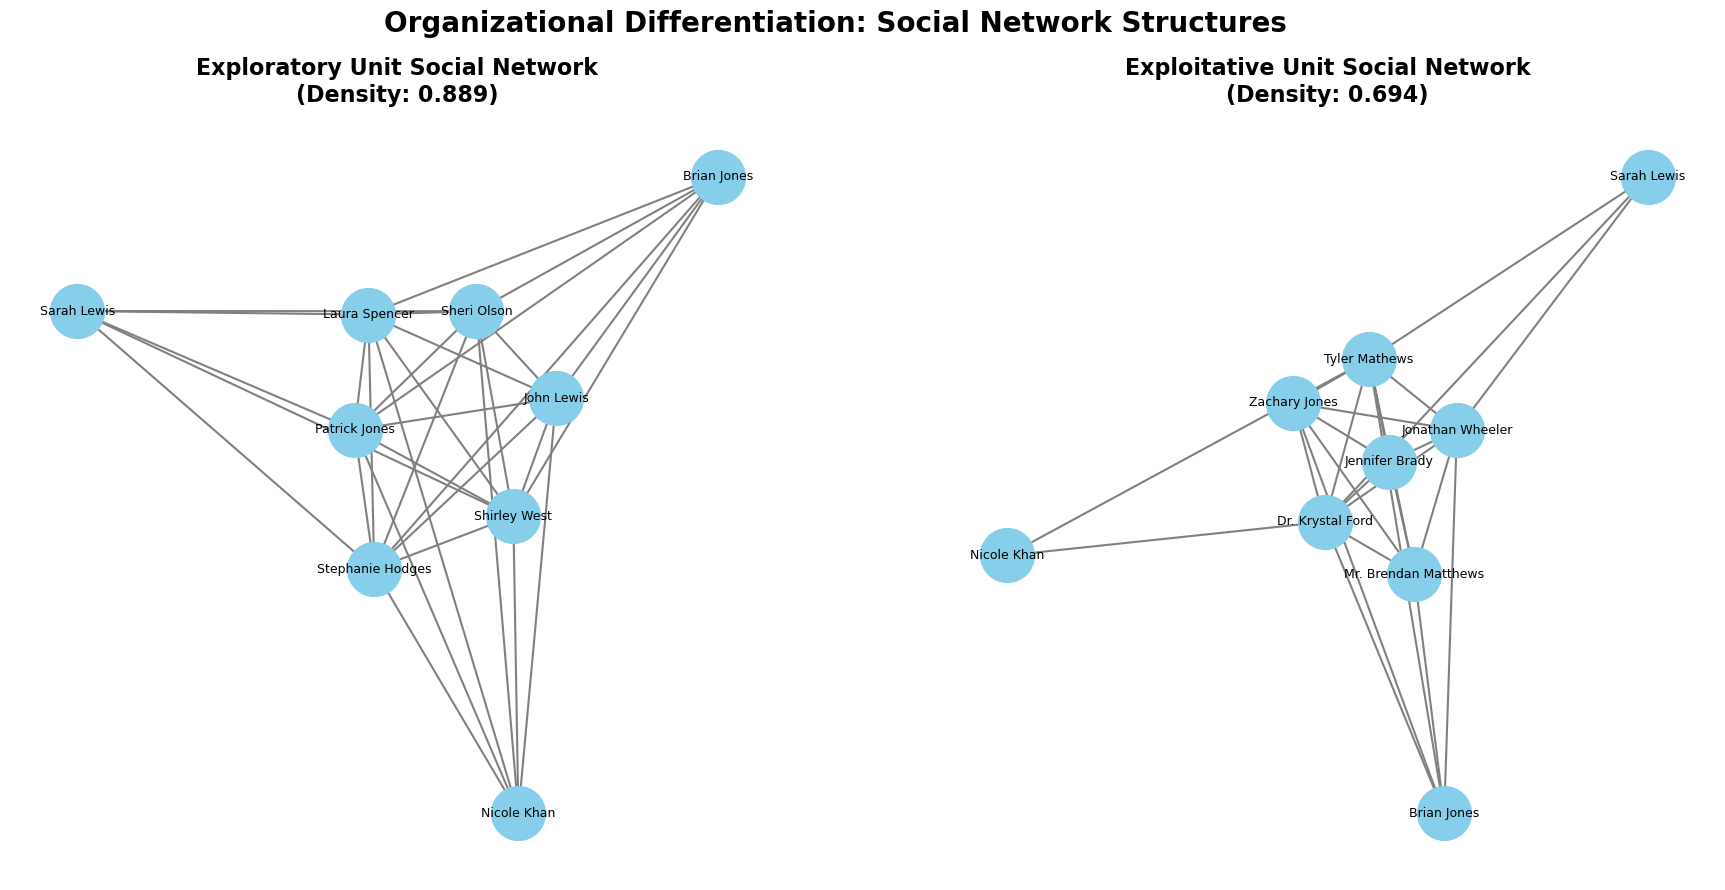

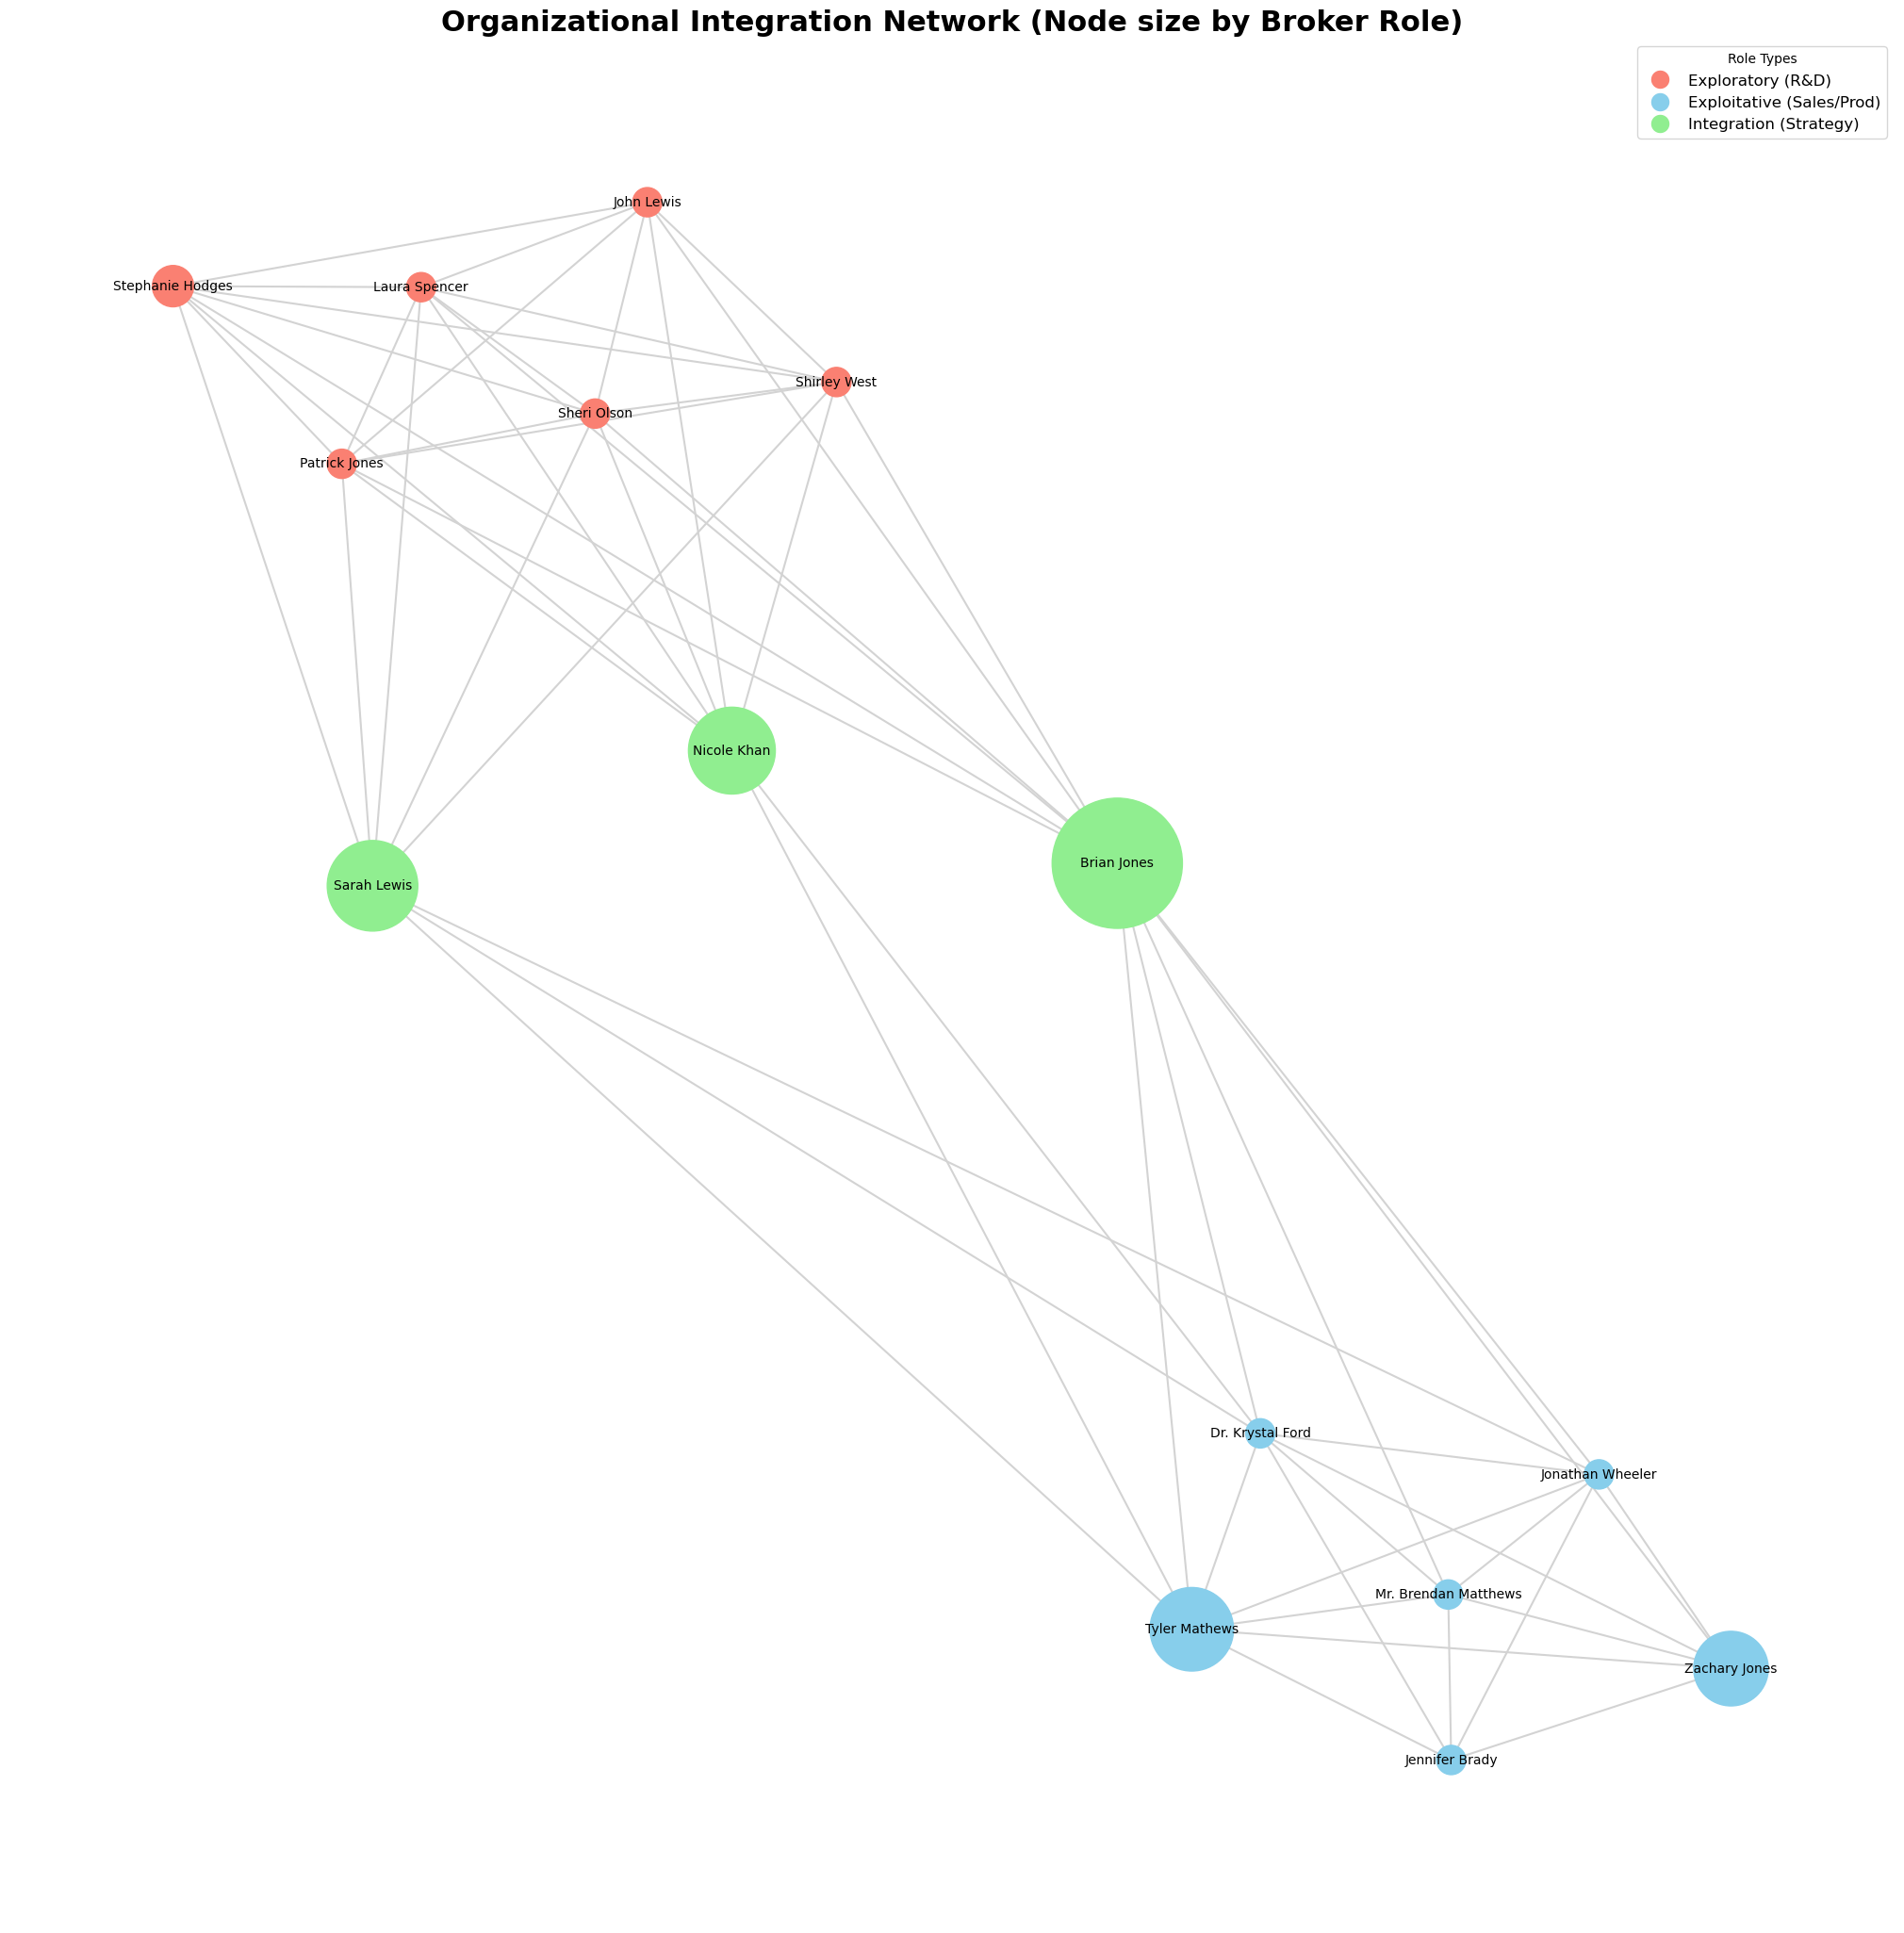

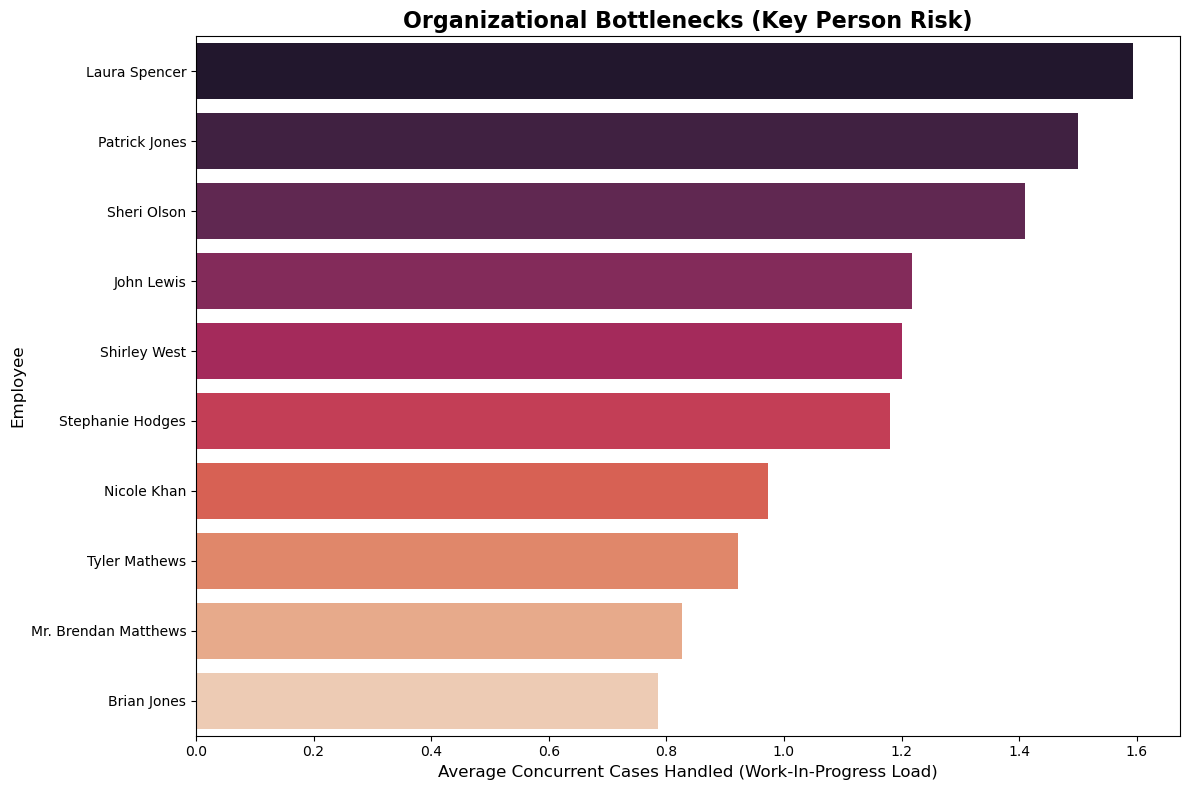

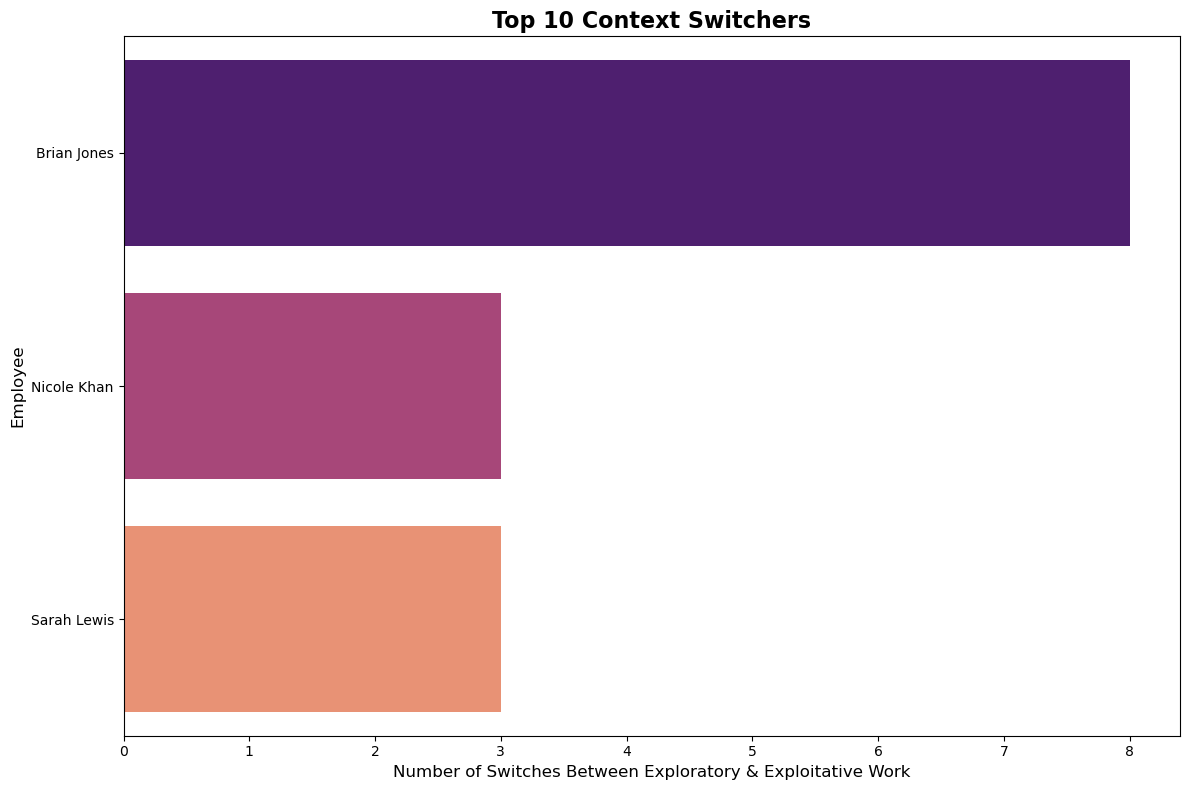

In [14]:
# --- 3. MAIN EXECUTION ---
if __name__ == '__main__':
    event_log = simulate_event_log(num_cases=100)
    analyze_organizational_differentiation(event_log)
    analyze_organizational_integration(event_log)
    analyze_organizational_bottlenecks(event_log)
    analyze_context_switching(event_log)
    
    print("✅ Full and Comprehensive Organizational Mining Analysis complete.")